Подключите нужные библиотеки и убедитесь в правильности выбранного устройства. Для начала советую писать на cpu, а на видеокарту переключаться, когда большая часть кода будет готова, чтобы не расходовать лишний ресурс. Чтобы подключить видеокарту, необходимо в настройках сменить среду выполнения на T4GPU. Если видеокарта подключилась успешно, блок кода ниже напечатает cuda.

In [1]:
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader

import os
from torchvision.datasets import MNIST
from torchvision import transforms as tfs

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


Для начала разберемся с данными. Мы будем использовать датасет mnist, картинки рукописных надписей десятичных цифр.

In [3]:
data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

# install for train and test
root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)

train_dataloader =  DataLoader(train_dataset, batch_size=128)
valid_dataloader =  DataLoader(val_dataset, batch_size=128)

In [4]:
X_batch, y_batch = next(iter(train_dataloader))
print(X_batch.shape, y_batch.shape)

torch.Size([128, 1, 28, 28]) torch.Size([128])


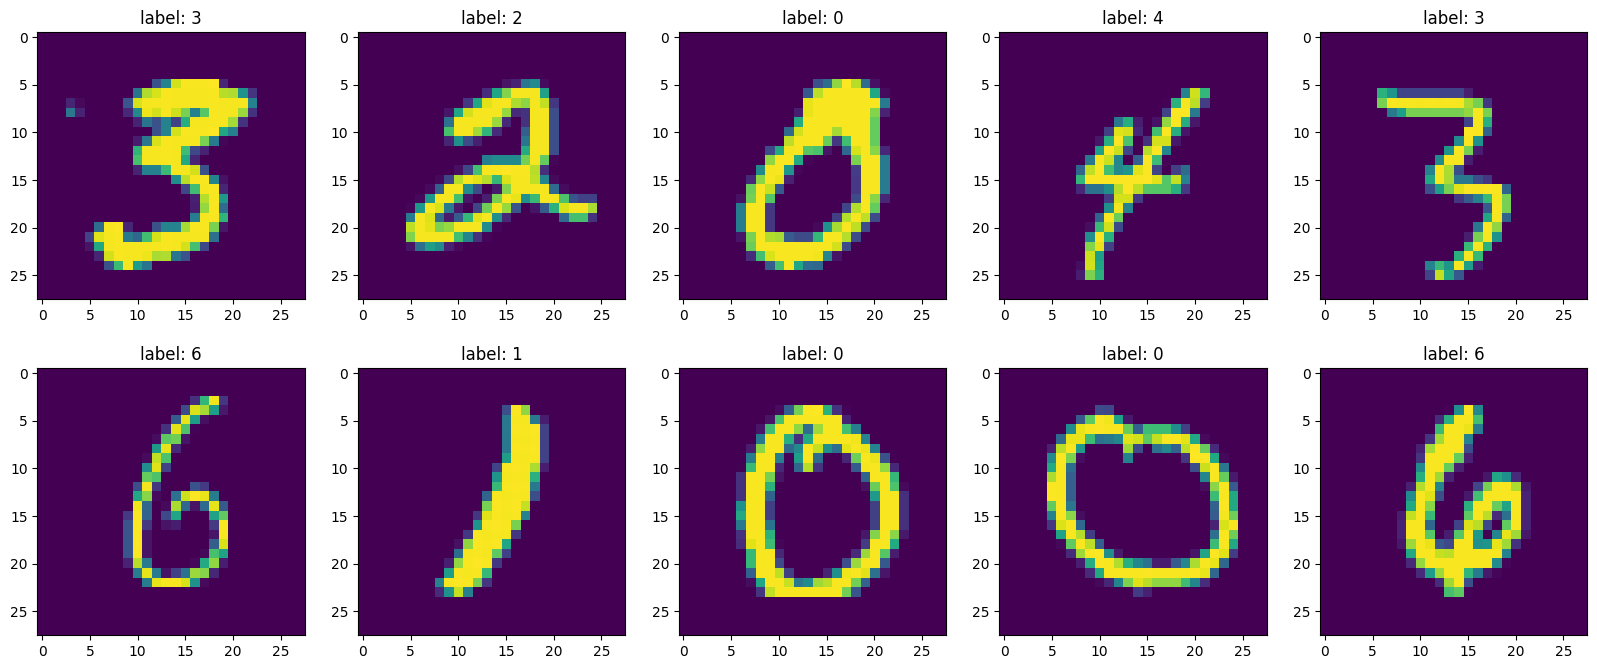

In [5]:
indexes = np.random.randint(X_batch.shape[0], size = 10)
plt.figure(figsize=(20, 8))
for i, index in enumerate(indexes):
  x = plt.subplot(2, 5, i+1)
  x.title.set_text(f"label: {y_batch[index]}")
  plt.imshow(X_batch[index][0])
plt.show()

Как видно с печатей, mnist состоит из одноканальных изображений 28x28 пикселей. Ваша задача - научить свои модели определять цифру на картинке.

Для начала реализуем класс линейной регрессии, используя возможности PyTorch. Дополните код ниже до корректной работы.

In [6]:
class LinearRegression(nn.Module):
    def __init__(self, in_features, out_features, bias=True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(in_features, out_features))
        self.bias = bias
        if bias:
            self.bias_weights = nn.Parameter(torch.randn(out_features))

    def forward(self, x):
        x = x @ self.weights
        if self.bias:
            x += self.bias_weights
        return x

На практике, вместо своего класса можно использовать nn.Linear, обладающий такой же сигнатурой.

In [7]:
linear_model = nn.Sequential(
    nn.Flatten(),
    LinearRegression(28 ** 2, 10) # классификация на 10 классов, значит и выходов столько же
).to(device) # так мы перемещаем модель на видеокарту

optimizer = torch.optim.Adam(linear_model.parameters())

criterion = nn.CrossEntropyLoss()

Sequential последовательно применит свои аргументы к пропускаемым через него аргументам, его удобно использовать для создания простых моделей или блоков внутри сложных. В качестве функции потерь берем стандартную для классификаторов кросс-энтропию. В качестве метрики будем использовать обычную accuracy, ее легко реализовать руками.

In [8]:
def learning_loop(tr_loader, val_loader, model, loss_fn, optim, epochs=20):
    tr_history = []
    val_history = []

    for epoch in range(epochs):
        tr_loss, tr_acc = train_epoch(tr_loader, model, loss_fn, optim)
        val_loss, val_acc = eval_epoch(val_loader, model, loss_fn)

        tr_history.append((tr_loss, val_loss))
        val_history.append((tr_acc, val_acc))

        print(f"epoch: {epoch + 1}; losses: {tr_loss}, {val_loss}; accuracy: {tr_acc}, {val_acc}")

    return tr_history, val_history



In [9]:
def train_epoch(data_loader, model, loss_fn, optim):
    model.train()

    total_loss = 0
    total_correct = 0
    total_samples = 0

    for x_batch, y_batch in data_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device) # перебрасываем входные данные на gpu
        optim.zero_grad() # обнуляем градиенты

        logits = model(x_batch)
        loss = loss_fn(logits, y_batch) # в данном случае лосс заточен на логиты, и сам применит softmax
        loss.backward() # пробрасываем градиенты
        optim.step() # делаем шаг оптимизатора

        loss_val = loss.item()
        preds = logits.argmax(-1)
        correct = (preds == y_batch).sum().item()  # считаем количество правильных предсказаний
        total_correct += correct
        total_samples += y_batch.size(0)  # общее количество образцов в батче
        total_loss += loss_val * x_batch.size(0)

    avg_loss = total_loss / total_samples  # средняя потеря за эпоху
    accuracy = total_correct / total_samples  # точность за эпоху

    return avg_loss, accuracy


In [10]:
def eval_epoch(data_loader, model, loss_fn):
    model.eval()  # Устанавливаем модель в режим оценки

    total_loss = 0.0  # Переменная для накопления потерь
    correct_predictions = 0  # Переменная для подсчета правильных предсказаний
    total_samples = 0  # Общее количество примеров

    for x_batch, y_batch in data_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        with torch.no_grad():  # Отключаем градиенты
            logits = model(x_batch)  # Прямой проход
            loss = loss_fn(logits, y_batch)  # Вычисляем потерю


        loss_val = loss.item()
        preds = logits.argmax(-1)  # Получаем предсказанные классы
        correct_predictions += (preds == y_batch).sum().item()  # Подсчет правильных предсказаний
        total_samples += y_batch.size(0)  # Обновление общего количества примеров
        total_loss += loss_val * x_batch.size(0)

    # Вычисляем среднюю потерю и точность за эпоху
    average_loss = total_loss / total_samples
    accuracy = correct_predictions / total_samples

    return average_loss, accuracy  # Возвращаем среднюю потерю и точность

In [11]:
loss, accuracy = learning_loop(train_dataloader, valid_dataloader, linear_model, criterion, optimizer)

epoch: 1; losses: 10.75142977142334, 4.35186731300354; accuracy: 0.3596, 0.5808
epoch: 2; losses: 3.5660543913523357, 2.491293092918396; accuracy: 0.6469833333333334, 0.7317
epoch: 3; losses: 2.3781386965433757, 1.851057393169403; accuracy: 0.7413166666666666, 0.7896
epoch: 4; losses: 1.870043424797058, 1.5287418440341949; accuracy: 0.78605, 0.8166
epoch: 5; losses: 1.5876415712038676, 1.3352133737802505; accuracy: 0.8114666666666667, 0.8364
epoch: 6; losses: 1.4050331016540527, 1.206589981663227; accuracy: 0.8277333333333333, 0.8469
epoch: 7; losses: 1.2758689039548239, 1.1126838246643542; accuracy: 0.8386333333333333, 0.8558
epoch: 8; losses: 1.1778917946179708, 1.0400538006722928; accuracy: 0.8479, 0.8608
epoch: 9; losses: 1.0996658174196878, 0.9806177605688572; accuracy: 0.8551833333333333, 0.8658
epoch: 10; losses: 1.0351645803610483, 0.9311154542207718; accuracy: 0.8602, 0.8695
epoch: 11; losses: 0.9809542253812155, 0.8895903195083141; accuracy: 0.8636, 0.873
epoch: 12; losses: 0

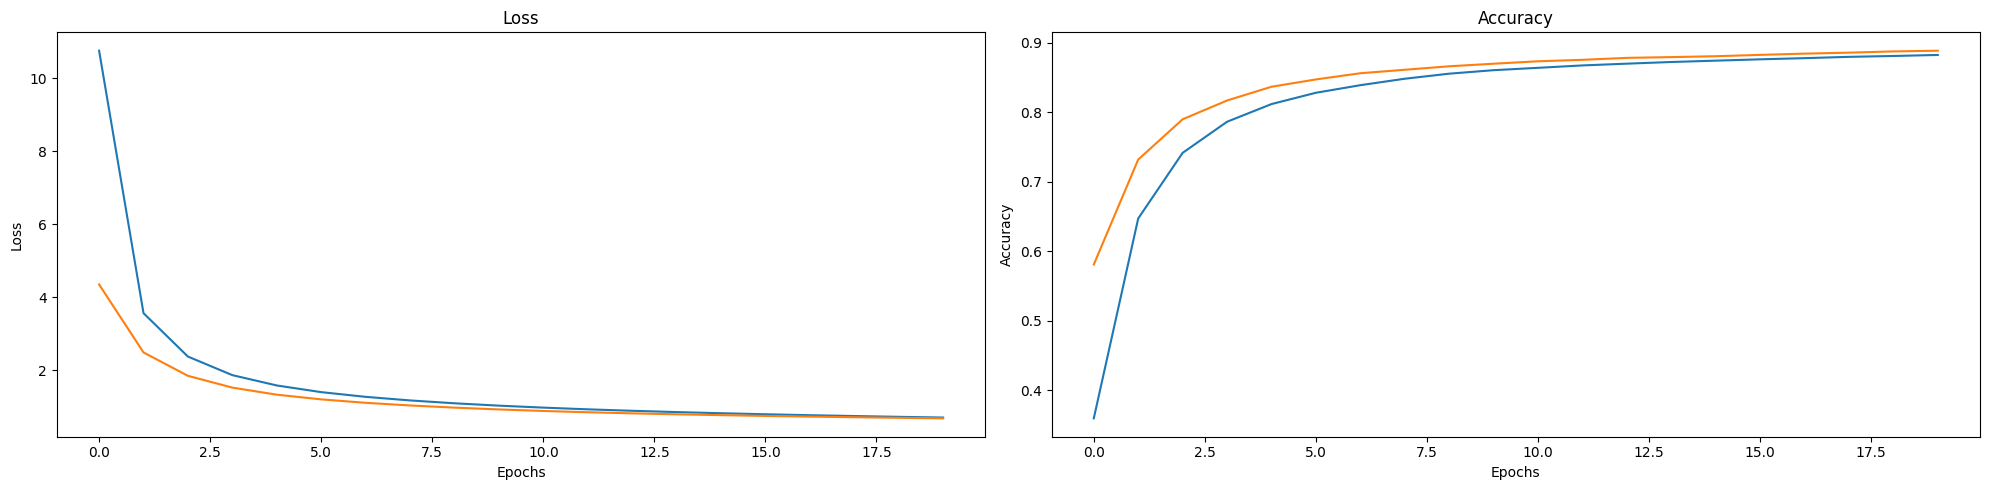

In [12]:
fig, axs = plt.subplots(figsize=(20, 5), ncols=2)

# Устанавливаем заголовки
axs[0].set_title("Loss")
axs[1].set_title("Accuracy")

# Строим графики, используя индексы списков
axs[0].plot(range(len(loss)), loss, label='Loss')
axs[1].plot(range(len(accuracy)), accuracy, label='Accuracy')

# Добавляем подписи осей
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")

# Показываем графики
plt.tight_layout()  # Для лучшего размещения элементов
plt.show()


In [13]:
class DenseNetwork(nn.Module):
    def __init__(self, in_features=28**2, out_features=10, activ=None):
        super().__init__()
        if activ is None:
            activ = nn.ReLU()
        self.flat = nn.Flatten()
        self.activ = activ
        self.linear_1 = nn.Linear(in_features, 128)
        self.linear_2 = nn.Linear(128, 128)  # Исправлено на nn.Linear
        self.linear_3 = nn.Linear(128, out_features)

    def forward(self, x):
        x = self.flat(x)
        x = self.linear_1(x)  # Пропускаем через первый линейный слой
        x = self.activ(x)     # Применяем активацию
        x = self.linear_2(x)  # Пропускаем через второй линейный слой
        x = self.activ(x)     # Применяем активацию
        x = self.linear_3(x)  # Пропускаем через третий линейный слой
        return x  # Возвращаем выходные данные


Можно ли было в данном случае не писать класс, а просто применить Sequential? Да, но оформив модель через класс мы имеем возможность потом модифицировать поведение уже обученной модели, обратившись к её полям.

epoch: 1; losses: 0.45411249907811485, 0.24461036719083787; accuracy: 0.8628166666666667, 0.924
epoch: 2; losses: 0.22191961205800376, 0.1695933150857687; accuracy: 0.93285, 0.9477
epoch: 3; losses: 0.15770005367000897, 0.13299733854830265; accuracy: 0.9512833333333334, 0.9612
epoch: 4; losses: 0.12162284167806307, 0.11668078494071961; accuracy: 0.9624333333333334, 0.965
epoch: 5; losses: 0.09990957236886025, 0.11051034191250801; accuracy: 0.9693833333333334, 0.9656
epoch: 6; losses: 0.08445353564321995, 0.11182670895084738; accuracy: 0.9738833333333333, 0.9652
epoch: 7; losses: 0.07477340185741584, 0.10735510192923248; accuracy: 0.9769666666666666, 0.9662
epoch: 8; losses: 0.06637831608057022, 0.10764498937986791; accuracy: 0.9793833333333334, 0.9659
epoch: 9; losses: 0.05768071637153625, 0.10875282899029554; accuracy: 0.9816166666666667, 0.9658
epoch: 10; losses: 0.05120652333696683, 0.10071052746269851; accuracy: 0.9837333333333333, 0.9694
epoch: 11; losses: 0.044615209773679575, 0.

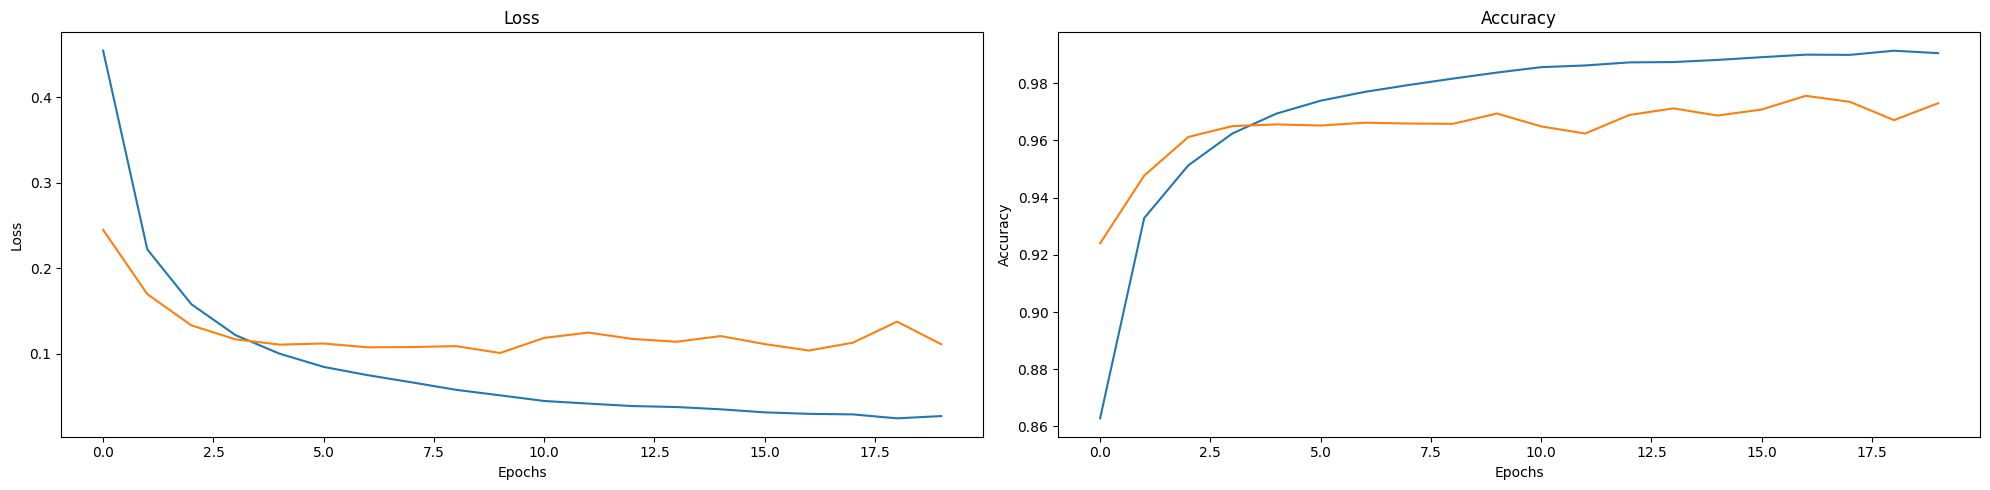

In [14]:
model_relu = DenseNetwork().to(device) # так мы перемещаем модель на видеокарту

optimizer = torch.optim.Adam(model_relu.parameters())

criterion_t = nn.CrossEntropyLoss()

loss, accuracy = learning_loop(train_dataloader, valid_dataloader, model_relu, criterion_t, optimizer)

fig, axs = plt.subplots(figsize=(20, 5), ncols=2)

# Устанавливаем заголовки
axs[0].set_title("Loss")
axs[1].set_title("Accuracy")

# Строим графики, используя индексы списков
axs[0].plot(range(len(loss)), loss, label='Loss')
axs[1].plot(range(len(accuracy)), accuracy, label='Accuracy')

# Добавляем подписи осей
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")

# Показываем графики
plt.tight_layout()  # Для лучшего размещения элементов
plt.show()

Создайте новые модели с другими функциями активации. Попробуйте: гиперболический тангенс, сигмоиду, ELU, LeakyReLU. Все их можно найти в torch.nn.functional. Обучите их, постройте и сравните между собой графики обучения.

epoch: 1; losses: 0.3975031267325083, 0.19836666415929793; accuracy: 0.8851833333333333, 0.9396
epoch: 2; losses: 0.18652534026304882, 0.15598700355887413; accuracy: 0.9439333333333333, 0.9525
epoch: 3; losses: 0.13797906646927197, 0.12538890409469605; accuracy: 0.9589, 0.961
epoch: 4; losses: 0.11247782948017121, 0.1183682845748961; accuracy: 0.9656833333333333, 0.964
epoch: 5; losses: 0.09489856737057369, 0.11506649600043893; accuracy: 0.9708166666666667, 0.9639
epoch: 6; losses: 0.08363550722201665, 0.13127161191105843; accuracy: 0.97435, 0.9596
epoch: 7; losses: 0.07544613913794358, 0.13696619432866575; accuracy: 0.97655, 0.9613
epoch: 8; losses: 0.0674589915573597, 0.1091041435226798; accuracy: 0.9786, 0.9676
epoch: 9; losses: 0.06245019150624673, 0.11581645156256855; accuracy: 0.98015, 0.9644
epoch: 10; losses: 0.061175926125049594, 0.12347983734570443; accuracy: 0.9802166666666666, 0.9606
epoch: 11; losses: 0.05518743341763814, 0.11412423063348978; accuracy: 0.98165, 0.9669
epoc

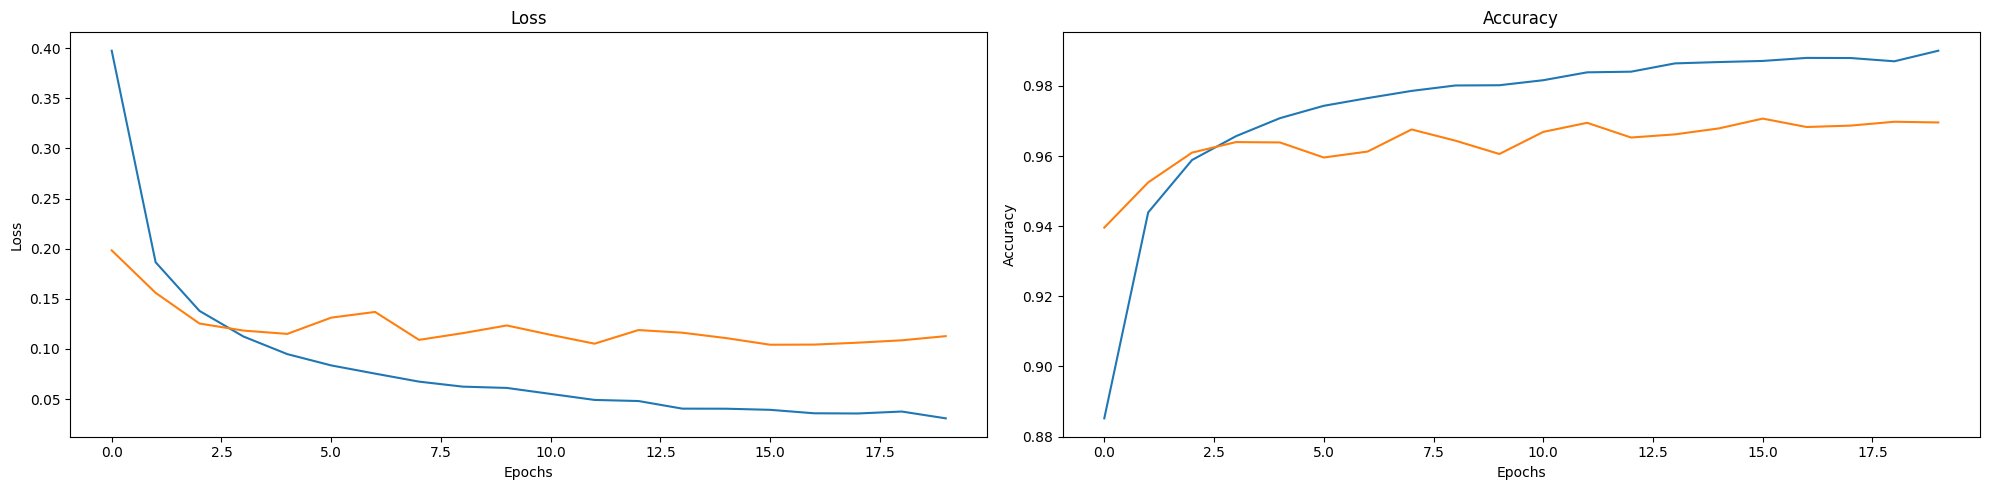

In [15]:
model_tanh = DenseNetwork(activ=nn.Tanh()).to(device) # так мы перемещаем модель на видеокарту

optimizer = torch.optim.Adam(model_tanh.parameters())

criterion_t = nn.CrossEntropyLoss()

loss, accuracy = learning_loop(train_dataloader, valid_dataloader, model_tanh, criterion_t, optimizer)

fig, axs = plt.subplots(figsize=(20, 5), ncols=2)

# Устанавливаем заголовки
axs[0].set_title("Loss")
axs[1].set_title("Accuracy")

# Строим графики, используя индексы списков
axs[0].plot(range(len(loss)), loss, label='Loss')
axs[1].plot(range(len(accuracy)), accuracy, label='Accuracy')

# Добавляем подписи осей
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")

# Показываем графики
plt.tight_layout()  # Для лучшего размещения элементов
plt.show()

epoch: 1; losses: 0.7508847847779592, 0.3098477460384369; accuracy: 0.7999, 0.9106
epoch: 2; losses: 0.2651732289711634, 0.2243449484705925; accuracy: 0.9231333333333334, 0.9343
epoch: 3; losses: 0.19622059883673987, 0.1789309837460518; accuracy: 0.9427333333333333, 0.9452
epoch: 4; losses: 0.1551001593629519, 0.15166018330454825; accuracy: 0.9553, 0.9532
epoch: 5; losses: 0.127503390032053, 0.13272691535055636; accuracy: 0.9631666666666666, 0.9595
epoch: 6; losses: 0.10737002571026484, 0.12148643687963485; accuracy: 0.9696, 0.9628
epoch: 7; losses: 0.0915293694893519, 0.11480394613668322; accuracy: 0.9741666666666666, 0.9653
epoch: 8; losses: 0.07874341129461924, 0.1126485978923738; accuracy: 0.9778, 0.9662
epoch: 9; losses: 0.06859054913421472, 0.11143405251577497; accuracy: 0.9805833333333334, 0.9669
epoch: 10; losses: 0.059916963189840314, 0.11092272847741842; accuracy: 0.9831833333333333, 0.9666
epoch: 11; losses: 0.05249936256110668, 0.11311220867782831; accuracy: 0.9855833333333

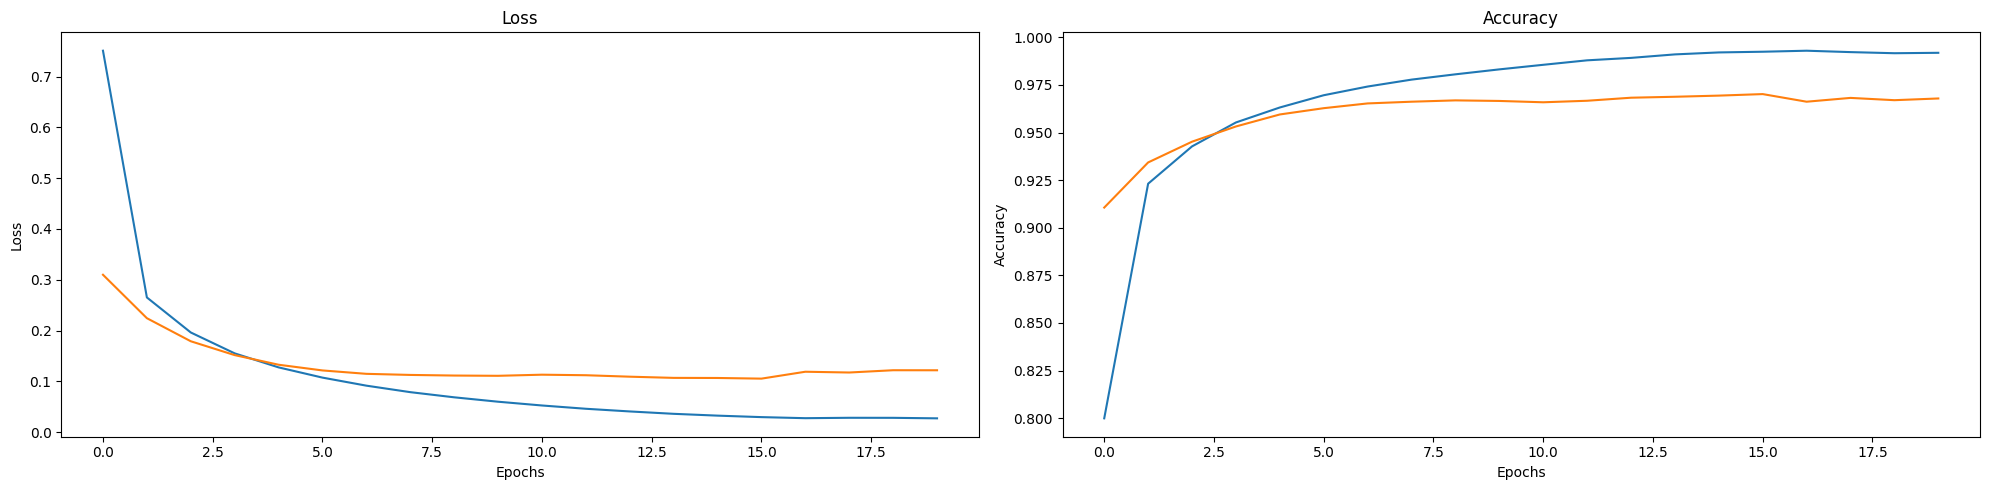

In [16]:
model_sigm = DenseNetwork(activ=nn.Sigmoid()).to(device) # так мы перемещаем модель на видеокарту

optimizer = torch.optim.Adam(model_sigm.parameters())

criterion_t = nn.CrossEntropyLoss()

loss, accuracy = learning_loop(train_dataloader, valid_dataloader, model_sigm, criterion_t, optimizer)

fig, axs = plt.subplots(figsize=(20, 5), ncols=2)

# Устанавливаем заголовки
axs[0].set_title("Loss")
axs[1].set_title("Accuracy")

# Строим графики, используя индексы списков
axs[0].plot(range(len(loss)), loss, label='Loss')
axs[1].plot(range(len(accuracy)), accuracy, label='Accuracy')

# Добавляем подписи осей
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")

# Показываем графики
plt.tight_layout()  # Для лучшего размещения элементов
plt.show()

epoch: 1; losses: 0.40534694975217184, 0.25422688698768614; accuracy: 0.8784833333333333, 0.9178
epoch: 2; losses: 0.1949163586616516, 0.17624061087965964; accuracy: 0.9410833333333334, 0.9456
epoch: 3; losses: 0.13446843990484875, 0.15034277249574662; accuracy: 0.9589666666666666, 0.9554
epoch: 4; losses: 0.10408571410775184, 0.12707659259438514; accuracy: 0.9675833333333334, 0.9609
epoch: 5; losses: 0.08330198440055052, 0.11491317873373627; accuracy: 0.9746, 0.9659
epoch: 6; losses: 0.06888647257039944, 0.10959916830118746; accuracy: 0.97885, 0.967
epoch: 7; losses: 0.05832038322687149, 0.0990392695138231; accuracy: 0.9820333333333333, 0.9709
epoch: 8; losses: 0.04988962235152721, 0.09887218764780555; accuracy: 0.9843833333333334, 0.9727
epoch: 9; losses: 0.04420380147397518, 0.0980247434013756; accuracy: 0.98605, 0.9727
epoch: 10; losses: 0.03975119094637533, 0.10589135764571839; accuracy: 0.9872666666666666, 0.9711
epoch: 11; losses: 0.03528265368777017, 0.12096450937213377; accura

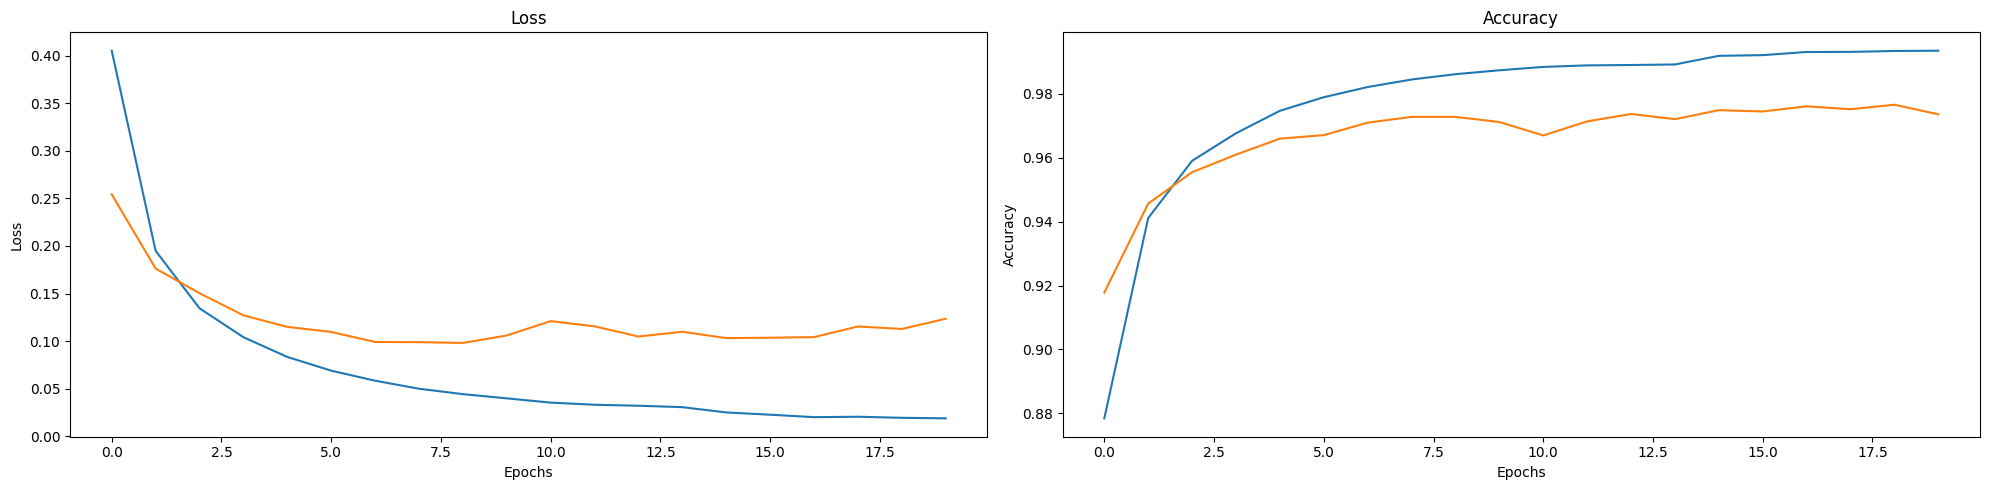

In [17]:
model_elu = DenseNetwork(activ=nn.ELU()).to(device) # так мы перемещаем модель на видеокарту

optimizer = torch.optim.Adam(model_elu.parameters())

criterion_t = nn.CrossEntropyLoss()

loss, accuracy = learning_loop(train_dataloader, valid_dataloader, model_elu, criterion_t, optimizer)

fig, axs = plt.subplots(figsize=(20, 5), ncols=2)

# Устанавливаем заголовки
axs[0].set_title("Loss")
axs[1].set_title("Accuracy")

# Строим графики, используя индексы списков
axs[0].plot(range(len(loss)), loss, label='Loss')
axs[1].plot(range(len(accuracy)), accuracy, label='Accuracy')

# Добавляем подписи осей
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")

# Показываем графики
plt.tight_layout()  # Для лучшего размещения элементов
plt.show()

epoch: 1; losses: 0.44928527535597484, 0.2547876638054848; accuracy: 0.8678, 0.9216
epoch: 2; losses: 0.2212276025334994, 0.17638657024502755; accuracy: 0.9332166666666667, 0.9436
epoch: 3; losses: 0.15584378455479939, 0.1472022134065628; accuracy: 0.9529666666666666, 0.9541
epoch: 4; losses: 0.11897194750507673, 0.12790431083440781; accuracy: 0.9639, 0.9619
epoch: 5; losses: 0.09949449925820032, 0.11875519531667232; accuracy: 0.9699166666666666, 0.9627
epoch: 6; losses: 0.08464355214039485, 0.10889148048758507; accuracy: 0.9744333333333334, 0.9656
epoch: 7; losses: 0.07576695573925972, 0.10319445195049047; accuracy: 0.9764, 0.9689
epoch: 8; losses: 0.06630450346171855, 0.10062205815725028; accuracy: 0.9793166666666666, 0.9699
epoch: 9; losses: 0.058641948767006395, 0.09860548150236718; accuracy: 0.9815333333333334, 0.9735
epoch: 10; losses: 0.05382205621550481, 0.10141865518640261; accuracy: 0.9828833333333333, 0.973
epoch: 11; losses: 0.04735552795877059, 0.10433420057832263; accurac

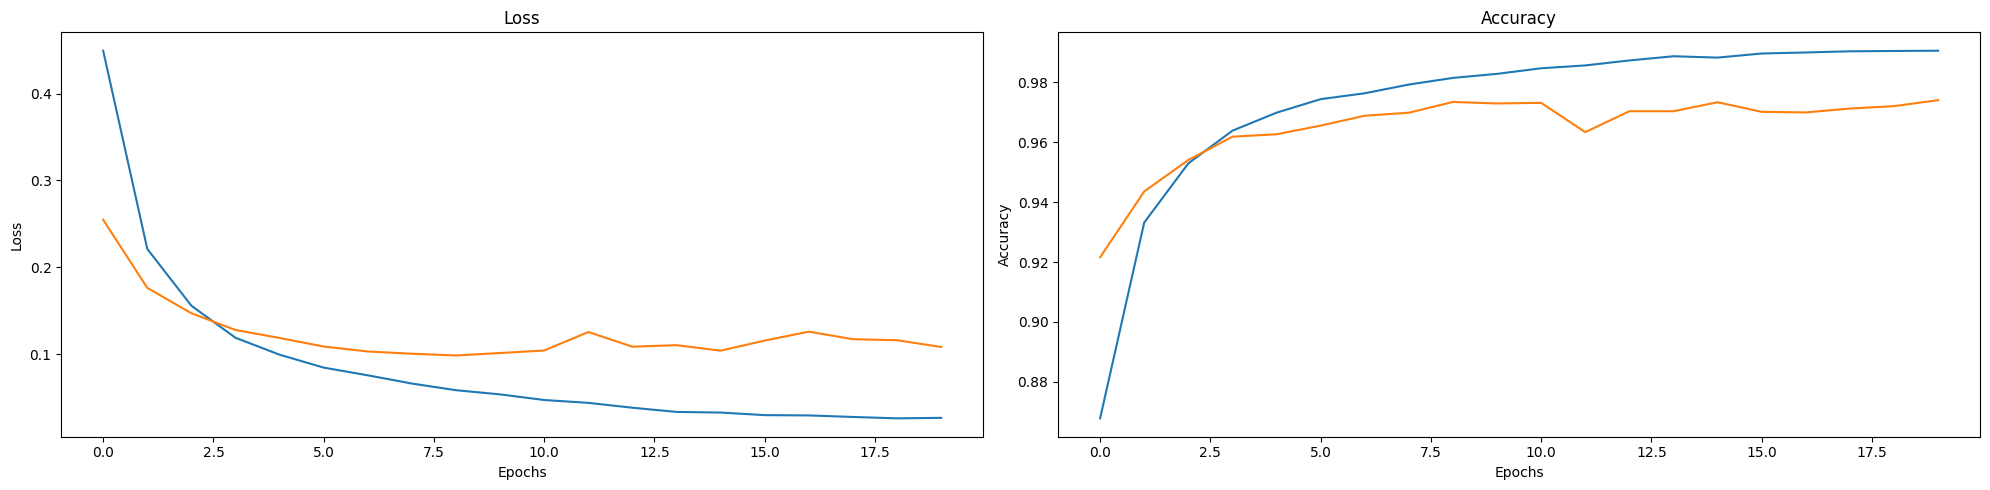

In [22]:
model_leakyrelu = DenseNetwork(activ=nn.LeakyReLU()).to(device) # так мы перемещаем модель на видеокарту

optimizer = torch.optim.Adam(model_leakyrelu.parameters())

criterion_t = nn.CrossEntropyLoss()

loss, accuracy = learning_loop(train_dataloader, valid_dataloader, model_leakyrelu, criterion_t, optimizer)

fig, axs = plt.subplots(figsize=(20, 5), ncols=2)

# Устанавливаем заголовки
axs[0].set_title("Loss")
axs[1].set_title("Accuracy")

# Строим графики, используя индексы списков
axs[0].plot(range(len(loss)), loss, label='Loss')
axs[1].plot(range(len(accuracy)), accuracy, label='Accuracy')

# Добавляем подписи осей
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")

# Показываем графики
plt.tight_layout()  # Для лучшего размещения элементов
plt.show()

Теперь вам предстоит написать свою первую сверточную нейросеть. Превая версия архитектура LeNet была предложена еще аж в 1998 году. Вам предлагается реализовать её в таком виде:


*   Свертки 3x3 переход из 1 карты в 6 + ReLU
*   MaxPooling 2x2
*   Свертки 3x3 переход из 6 карт в 16 + ReLU
*   MaxPooling 2x2
*   Выпрямление (flatten)
*   Полносвязный слой, 120 нейронов + ReLU
*   Полносвязный слой, 84 нейрона + ReLU
*   Классификационный слой, 10 нейронов

Свертки можно брать из nn.Conv2d, пулинг - из nn.MaxPool2d, их сигнатуры можно загуглить.





In [23]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()

        # Первый свёрточный блок
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3)  # Свертка 3x3, 1 канал на входе, 6 на выходе
        self.relu1 = nn.ReLU()  # Активация ReLU
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # MaxPooling 2x2

        # Второй свёрточный блок
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3)  # Свертка 3x3, 6 каналов на входе, 16 на выходе
        self.relu2 = nn.ReLU()  # Активация ReLU
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # MaxPooling 2x2

        # Полносвязные слои
        self.flatten = nn.Flatten()  # Выпрямление
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # Полносвязный слой с 120 нейронами
        self.relu3 = nn.ReLU()  # Активация ReLU
        self.fc2 = nn.Linear(120, 84)  # Полносвязный слой с 84 нейронами
        self.relu4 = nn.ReLU()  # Активация ReLU
        self.fc3 = nn.Linear(84, 10)  # Классификационный слой с 10 нейронами (для 10 классов)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        x = self.flatten(x)

        x = self.fc1(x)
        x = self.relu3(x)

        x = self.fc2(x)
        x = self.relu4(x)

        x = self.fc3(x)

        return x

epoch: 1; losses: 0.3963662762482961, 0.10979763686358929; accuracy: 0.8862, 0.9665
epoch: 2; losses: 0.1070794488325715, 0.07896514772623778; accuracy: 0.9668333333333333, 0.9745
epoch: 3; losses: 0.07476056103855372, 0.06073756196945906; accuracy: 0.9769666666666666, 0.9796
epoch: 4; losses: 0.05723729083364208, 0.05108166347164661; accuracy: 0.98245, 0.9824
epoch: 5; losses: 0.04590202346369624, 0.04617948326384649; accuracy: 0.98595, 0.9835
epoch: 6; losses: 0.03813167076986283, 0.045719185985298824; accuracy: 0.9882666666666666, 0.9844
epoch: 7; losses: 0.03205633700185766, 0.04691185821697581; accuracy: 0.9903166666666666, 0.9845
epoch: 8; losses: 0.02770359714020354, 0.04899396213972941; accuracy: 0.9916166666666667, 0.9845
epoch: 9; losses: 0.023679701443078616, 0.04707481226420496; accuracy: 0.9929166666666667, 0.9847
epoch: 10; losses: 0.020797422941743086, 0.0549540125237545; accuracy: 0.9936, 0.9831
epoch: 11; losses: 0.020120539393570894, 0.05950039222175255; accuracy: 0.9

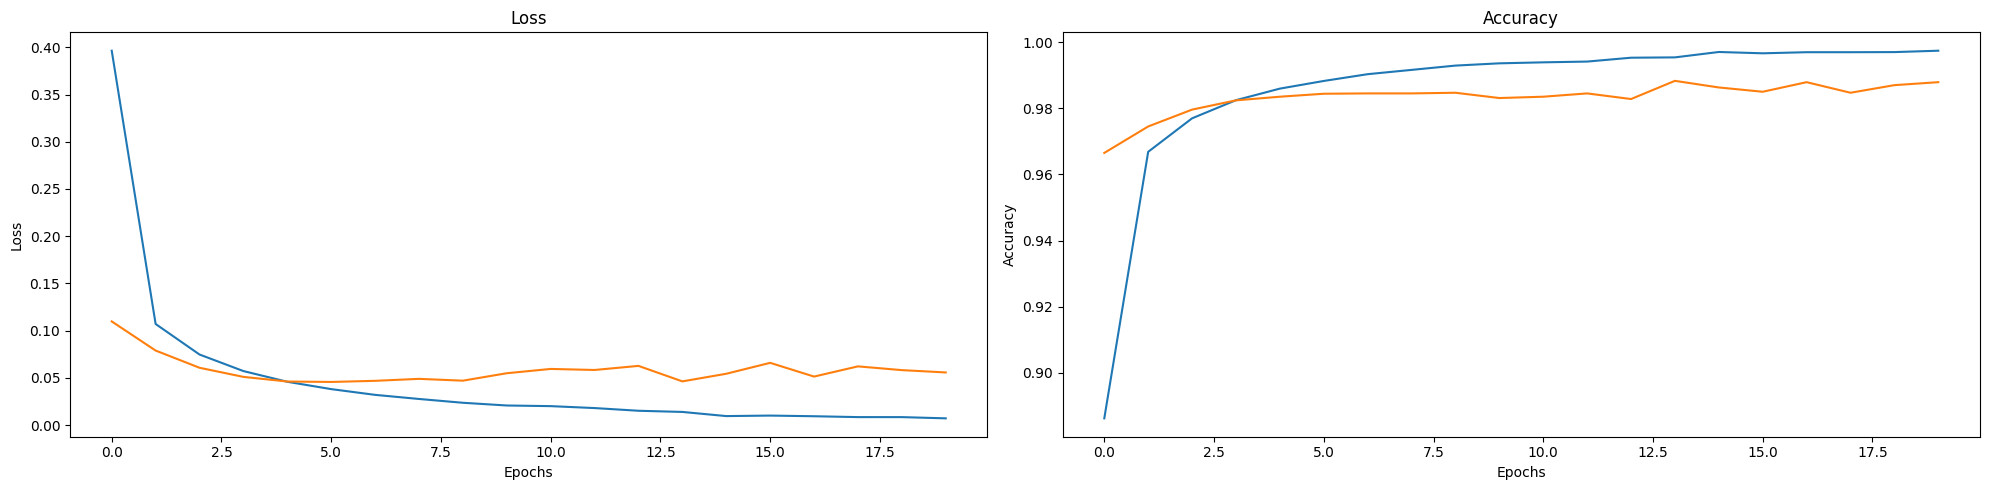

In [24]:
model_svert = LeNet().to(device) # так мы перемещаем модель на видеокарту

optimizer = torch.optim.Adam(model_svert.parameters())

criterion_t = nn.CrossEntropyLoss()

loss, accuracy = learning_loop(train_dataloader, valid_dataloader, model_svert, criterion_t, optimizer)

fig, axs = plt.subplots(figsize=(20, 5), ncols=2)

# Устанавливаем заголовки
axs[0].set_title("Loss")
axs[1].set_title("Accuracy")

# Строим графики, используя индексы списков
axs[0].plot(range(len(loss)), loss, label='Loss')
axs[1].plot(range(len(accuracy)), accuracy, label='Accuracy')

# Добавляем подписи осей
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")

# Показываем графики
plt.tight_layout()  # Для лучшего размещения элементов
plt.show()

Проанализируйте полученные результаты, постройте сравнительные графики для точности на валидационной выборке у трех разных моделей. В качестве задачи со звездочкой, можете попробовать поиграть со своей архитектурой сверточной нейронной сети (можно варьировать количество слоев, количество нейронов в них, добавлять в свертки padding, а в полносвязную часть skip-connections).